In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import ipywidgets as widgets
from matplotlib.ticker import FuncFormatter
from scipy.signal import butter, lfilter, iirpeak, iirnotch
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import freqz
from IPython.display import display, HTML
import pyfar as pf
from functools import partial
import math
import soundfile as sf

%matplotlib widget

### Import audio ###

In [5]:
# audio = {}
#audio["airplane_overhead"] = pf.io.read_audio("./airplane_overhead.wav")
#audio["coffee_shop"] = pf.io.read_audio("./coffee_shop.wav")
#audio["heavy_traffic"] = pf.io.read_audio("./heavy_traffic.wav")
# audio["jet_engines"] = pf.io.read_audio("./jet_engines.mp3")
#audio["wind_tonal"] = pf.io.read_audio("./wind_tonal.wav")
#audio["rumble"] = pf.io.read_audio("./rumble.wav")
# audio["wind_tonal2"] = pf.io.read_audio("./wind_tonal2.wav")
# audio["thunder"] = pf.io.read_audio("./thunder.wav")
# audio["coffee_shop"] = pf.io.read_audio("./coffee_shop.wav")
# audio["pink_noise"] = pf.io.read_audio("./pink_noise.wav")

### Define Audio Player Widgets ###

In [6]:

# Play audio
def play_audio(audio, sample_rate):
    sd.play(audio.time.T, sample_rate)


# Stop audio
def stop_audio(b):
    sd.stop()



def create_play_button(description, signal):
    button = widgets.Button(description=description)
    button.layout = widgets.Layout(border='1px solid black', border_radius='10px')
    button.on_click(lambda b, audio=signal: play_audio(audio, audio.sampling_rate))
    button.layout.width = '250px'
    return button

stop_button = widgets.Button(description="Stop Audio")
stop_button.layout = widgets.Layout(border='1px solid black', border_radius='10px')
stop_button.on_click(stop_audio)

print(sd.query_devices())

# Custom CSS to style the ipywidget buttons
custom_css = """
<style>
    .jupyter-widgets button {
        background-color: white !important;
        border: 1px solid black !important;
        border-radius: 10px !important;
        margin: 10px;
    }
    .widget-container {
        display: flex;
        flex-direction: row;
        justify-content: start;
        align-items: center;
    }
</style>
"""

# Display the custom CSS
display(HTML(custom_css))


> 0 MacBook Pro Microphone, Core Audio (3 in, 0 out)
< 1 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  2 Microsoft Teams Audio, Core Audio (2 in, 2 out)


### Define Filters ###

In [7]:
"""Get a FilterIIR Object representing the butterworth filter"""
def get_butterworth(signal, order, cutoff, sample_rate, btype='lowpass'):
    return pf.dsp.filter.butterworth(signal, order, cutoff, btype, sample_rate)



""" Get a FilterIIR Object representing the bell filter"""
def get_bell(signal, center_freq, gain, bandwidth, sample_rate):
    return pf.dsp.filter.bell(signal, center_freq, gain, center_freq/bandwidth, sampling_rate=sample_rate)



""" Get a high shelve filter """
def get_high_shelve(signal, frequency, frequency_type, gain=-20, bandwidth=5, sampling_rate=44100):
    return pf.dsp.filter.high_shelve_cascade(signal, frequency, frequency_type=frequency_type, gain=gain, bandwidth=bandwidth, sampling_rate=sampling_rate)



""" Get a low shelve filter """
def get_low_shelve(signal, frequency, frequency_type, gain=-20, bandwidth=5, sampling_rate=44100):
    return pf.dsp.filter.low_shelve_cascade(signal, frequency, frequency_type=frequency_type, gain=gain, bandwidth=bandwidth, sampling_rate=sampling_rate)



""" Apply passive filter """
def apply_passive_filter(signal):
    # Passive curve #
    signal = get_high_shelve(signal, 100, 'lower', gain=-20, bandwidth=3.322, sampling_rate=None)[0]
    signal = get_high_shelve(signal, 1000, 'lower', gain=-21, bandwidth=1, sampling_rate=None)[0]
    signal = get_bell(signal, 10000, 20, 500, sample_rate=None)
    signal = get_bell(signal, 4000, 15, 500, sample_rate=None)
    signal = get_bell(signal, 300, 15, 100, sample_rate=None)
    return signal


def apply_passive_filter_sony(signal):
    # Passive curve #
    signal = get_high_shelve(signal, 200, 'lower', gain=-25, bandwidth=2, sampling_rate=None)[0]
    signal = get_high_shelve(signal, 2000, 'lower', gain=-25, bandwidth=3.3, sampling_rate=None)[0]
    return signal



""" Apply active filter"""
def apply_active_filter(signal):
    # Active curve # 
    signal = get_low_shelve(signal,  15, 'lower', gain=5, bandwidth=1, sampling_rate=None)[0]
    signal = get_high_shelve(signal, 30, 'lower', gain=-45, bandwidth=1, sampling_rate=None)[0]
    signal = get_high_shelve(signal, 100, 'lower', gain=45, bandwidth=3, sampling_rate=None)[0]
    signal = get_bell(signal, 900, 5, 100, sample_rate=None)
    signal = get_bell(signal, 3500, 10, 500, sample_rate=None)
    signal = get_bell(signal, 2000, -5, 500, sample_rate=None)
    signal = get_bell(signal, 300, 10, 500, sample_rate=None)
    return signal



"""Create Active Filter Simulator"""
def active_filter_simulator(signal, f_cut, f_peak, f_ret, max_gain, starting_gain, sampling_rate=None, reduce=False):
    if signal is None:
        filter1 = pf.dsp.filter.low_shelve_cascade(signal, f_cut, frequency_type='lower', gain=starting_gain, bandwidth=1, sampling_rate=sampling_rate)[0]
        filter2 = pf.dsp.filter.high_shelve_cascade(signal, f_cut, frequency_type='lower', gain=(max_gain-starting_gain), bandwidth=math.log(f_peak/f_cut, 2), sampling_rate=sampling_rate)[0]
        filter3 = pf.dsp.filter.high_shelve_cascade(signal, f_peak, frequency_type='lower', gain=(2*starting_gain-max_gain), bandwidth=math.log(f_ret/f_peak, 2), sampling_rate=sampling_rate)[0]
        return [filter1, filter2, filter3]
    else:
        if reduce:
            signal = pf.dsp.filter.low_shelve_cascade(signal, f_cut, frequency_type='lower', gain=starting_gain*0.9, bandwidth=1)[0]
            signal = pf.dsp.filter.high_shelve_cascade(signal, f_cut, frequency_type='lower', gain=(max_gain-starting_gain)*0.9, bandwidth=math.log(f_peak/f_cut, 2))[0]
            signal = pf.dsp.filter.high_shelve_cascade(signal, f_peak, frequency_type='lower', gain=(2*starting_gain-max_gain)*0.9, bandwidth=math.log(f_ret/f_peak, 2))[0]
        else:
            signal = pf.dsp.filter.low_shelve_cascade(signal, f_cut, frequency_type='lower', gain=starting_gain, bandwidth=1)[0]
            signal = pf.dsp.filter.high_shelve_cascade(signal, f_cut, frequency_type='lower', gain=(max_gain-starting_gain), bandwidth=math.log(f_peak/f_cut, 2))[0]
            signal = pf.dsp.filter.high_shelve_cascade(signal, f_peak, frequency_type='lower', gain=(2*starting_gain-max_gain), bandwidth=math.log(f_ret/f_peak, 2))[0]
        return signal



### Define Plotting Functions ###

In [8]:
""" Define custom formatter for axis ticks"""
def custom_formatter(x, pos):
    if int(x) >= 1000:
        return f'{int(x/1000)}k'
    else:
        return f'{int(x)}'
    
    
"""
Define function to plot magnitude spectrum (SPL) of signals
    @nrows: number of signals
    @ncolumns: number of channels pro signal
    @data: a dictionary in form of {signal_type}:{data}

"""
def plot_freq(nrows, ncolumns, data, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(nrows, ncolumns, figsize=(15, 15))
    row = 0
    column = 0
    ticks = [10, 20, 40, 60, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000]
    for type, signal in data.items():
        if signal.signal_type == "energy":
            magnitude = 20 * np.log10(abs(signal.freq))
        else: 
            magnitude = 10 * np.log10(abs(signal.freq))    
        for channel in range(0, signal.cshape[0]):
            ax[row, column].plot(signal.frequencies, magnitude[channel, :], label=f'{type} - Channel {channel}')
            ax[row, column].set_xscale("log")
            ax[row, column].get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
            ax[row, column].set_xlabel("Frequencies [Hz]")
            ax[row, column].set_xticks(ticks)
            ax[row, column].set_xlim(10, 20000)
            ax[row, column].set_ylabel("Magnitude [dB SPL]")
            ax[row, column].legend()
            ax[row, column].grid()
            column += 1
        row += 1
        column = 0
    plt.tight_layout()
    return fig, ax



"""Plot Filter magnitude spectrum"""
def plot_impulse_response(filters, descriptors=None):
    impulse = pf.signals.impulse(2**21)
    fig, ax = plt.subplots(figsize=(15,5))
    for index, filter in enumerate(filters):
        impulse_response = filter.process(impulse)
        if impulse_response.signal_type == "energy":
            magnitude = 20 * np.log10(abs(impulse_response.freq))
        else: 
            magnitude = 10 * np.log10(abs(impulse_response.freq))
        ax.plot(impulse_response.frequencies, magnitude[0], label=f'{descriptors[index]}')
    ticks = [10, 20, 40, 60, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000]
    ax.set_xscale("log")
    ax.get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
    ax.set_xlabel("Frequencies [Hz]")
    ax.set_xticks(ticks)
    ax.set_xlim(10, 20000)
    ax.set_ylabel("Magnitude [dB]")
    ax.set_ylim(-50, 0)
    ax.legend()
    ax.grid()
    return ax, fig



"""Plot impulse response cascade"""
def plot_impulse_response_cascade(cascade_filters, descriptors=None, fig=None, ax=None):
    impulse_response = pf.signals.impulse(2**21)
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(15,5))
    for index, filters in enumerate(cascade_filters):
        for filter in filters:
            impulse_response = filter.process(impulse_response)
        if impulse_response.signal_type == "energy":
            magnitude = 20 * np.log10(abs(impulse_response.freq))
        else: 
            magnitude = 10 * np.log10(abs(impulse_response.freq))
        ax.plot(impulse_response.frequencies, magnitude[0], label=f'{descriptors[index]}')
        impulse_response = pf.signals.impulse(2**21)
    ticks = [10, 20, 40, 60, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000]
    ax.set_xscale("log")
    ax.get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
    ax.set_xlabel("Frequencies [Hz]")
    ax.set_xticks(ticks)
    ax.set_xlim(1, 20000)
    ax.set_ylabel("Magnitude [dB]")
    ax.set_ylim(-50, 20)
    ax.legend()
    ax.grid()
    return fig, ax

### Plot Audio Signals ###

In [9]:
#plot_freq(len(audio.keys()), 2, audio)

### Butterworth Bandstop Magnitude Spectrum ###

In [10]:
# bandstops = []
# bandstops_descriptors = []
# for i in range(1,10):
#     bandstops.append(get_butterworth(None, i, [100, 1000], sample_rate=44100, btype='bandstop'))
#     bandstops_descriptors.append(f"{i}-Order")
# plot_impulse_response(bandstops, bandstops_descriptors)

### Approximate ANC Curve ###

(<Figure size 1500x500 with 1 Axes>,
 <Axes: xlabel='Frequencies [Hz]', ylabel='Magnitude [dB]'>)

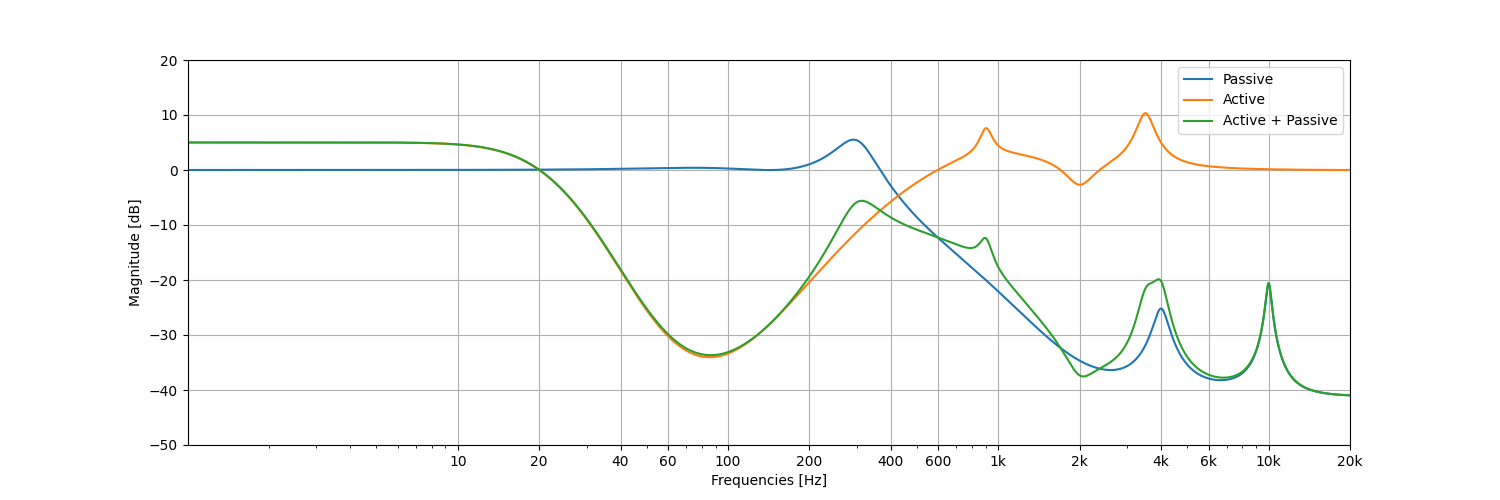

In [11]:
# Passive curve #

high_shelve1 = get_high_shelve(None, 100, 'lower', sampling_rate=44100, gain=-20, bandwidth=3.322)
high_shelve2 = get_high_shelve(None, 1000, 'lower', sampling_rate=44100, gain=-21, bandwidth=1)
passive_bell1 = get_bell(None, 10000, 20, 500, sample_rate=44100)
passive_bell2 = get_bell(None, 4000, 15, 500, sample_rate=44100)
passive_bell3 = get_bell(None, 300, 15, 100, sample_rate=44100)

# Active curve # 
low_shelve1 = get_low_shelve(None,  15, 'lower', gain=5, bandwidth=1, sampling_rate=44100)
high_shelve3 = get_high_shelve(None, 30, 'lower', sampling_rate=44100, gain=-45, bandwidth=1)
high_shelve4 = get_high_shelve(None, 100, 'lower', sampling_rate=44100, gain=45, bandwidth=3)
active_bell1 = get_bell(None, 900, 5, 100, sample_rate=44100)
active_bell2 = get_bell(None, 3500, 10, 500, sample_rate=44100)
active_bell3 = get_bell(None, 2000, -5, 500, sample_rate=44100)
active_bell4 = get_bell(None, 300, 10, 500, sample_rate=44100)


plot_impulse_response_cascade([[high_shelve1[0], high_shelve2[0], passive_bell1, passive_bell2, passive_bell3],
                               [low_shelve1[0], high_shelve3[0], high_shelve4[0], active_bell1, active_bell2, active_bell3, active_bell4], 
                               [high_shelve1[0], high_shelve2[0], passive_bell1, passive_bell2, passive_bell3, low_shelve1[0], high_shelve3[0], high_shelve4[0], active_bell1, active_bell2, active_bell3, active_bell4]], ['Passive', 'Active', 'Active + Passive'])


### Create 3 active different filters for listening test ###

(<Figure size 1500x500 with 1 Axes>,
 <Axes: xlabel='Frequencies [Hz]', ylabel='Magnitude [dB]'>)

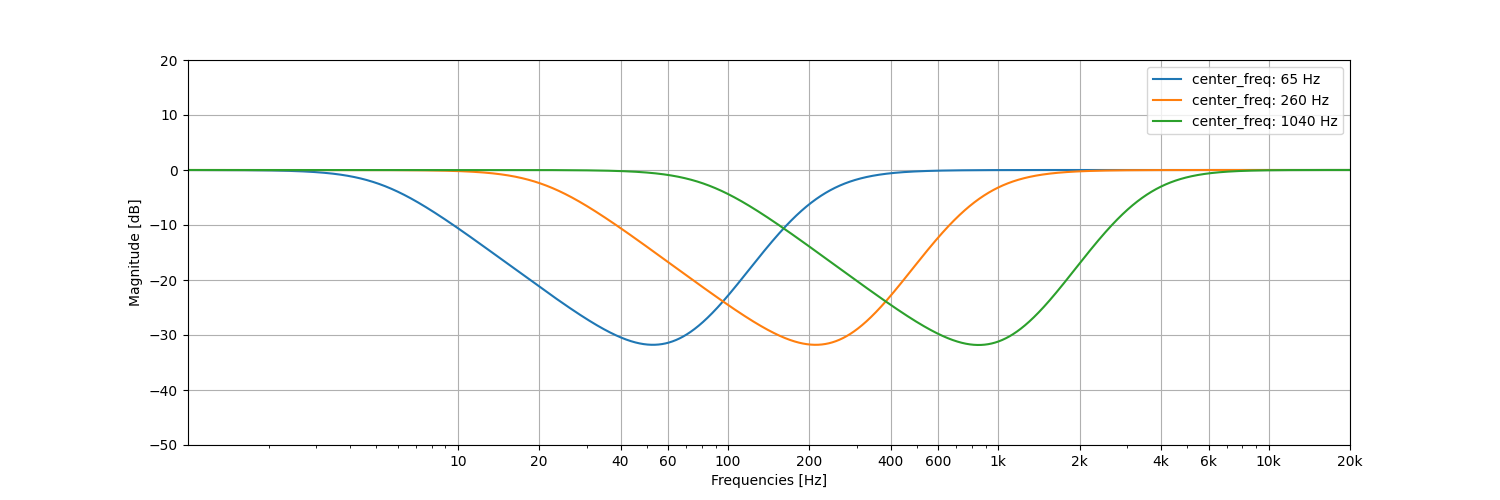

In [12]:
def create_testing_filter(left_slope, right_slope, starting_gain, max_gain, center_freq, signal=None, mismatch = False):
    f_lower = center_freq/(2**abs((max_gain-starting_gain)/left_slope))
    if signal is not None:
        if mismatch:
            signal = pf.dsp.filter.low_shelve_cascade(signal, f_lower, frequency_type='lower', gain=starting_gain*0.8, bandwidth=1)[0]
            signal = pf.dsp.filter.high_shelve_cascade(signal, f_lower, frequency_type='lower', gain=(max_gain-starting_gain)*0.8, slope=left_slope)[0]
            signal = pf.dsp.filter.high_shelve_cascade(signal, center_freq, frequency_type='lower', gain=(2*starting_gain-max_gain)*0.8, slope=right_slope)[0]         
            return signal
        else:
            signal = pf.dsp.filter.low_shelve_cascade(signal, f_lower, frequency_type='lower', gain=starting_gain, bandwidth=1)[0]
            signal = pf.dsp.filter.high_shelve_cascade(signal, f_lower, frequency_type='lower', gain=(max_gain-starting_gain), slope=left_slope)[0]
            signal = pf.dsp.filter.high_shelve_cascade(signal, center_freq, frequency_type='lower', gain=(2*starting_gain-max_gain), slope=right_slope)[0]
            return signal
    else: 
        filter1 = pf.dsp.filter.low_shelve_cascade(signal, f_lower, frequency_type='lower', gain=starting_gain, bandwidth=1, sampling_rate=44100)[0]
        filter2 = pf.dsp.filter.high_shelve_cascade(signal, f_lower, frequency_type='lower', gain=(max_gain-starting_gain), slope=left_slope, sampling_rate=44100)[0]
        filter3 = pf.dsp.filter.high_shelve_cascade(signal, center_freq, frequency_type='lower', gain=(2*starting_gain-max_gain), slope=right_slope, sampling_rate=44100)[0]

        return [filter1, filter2, filter3]


testing_filters = []
testing_descriptors = []
testing_freq = [65, 260, 1040]

for freq in testing_freq:
    testing_filters.append(create_testing_filter(-11, 25, 0, -40, freq))
    testing_descriptors.append(f"center_freq: {freq} Hz")

plot_impulse_response_cascade(testing_filters, testing_descriptors)


### Active + Passive curve ###

(<Figure size 1500x500 with 1 Axes>,
 <Axes: xlabel='Frequencies [Hz]', ylabel='Magnitude [dB]'>)

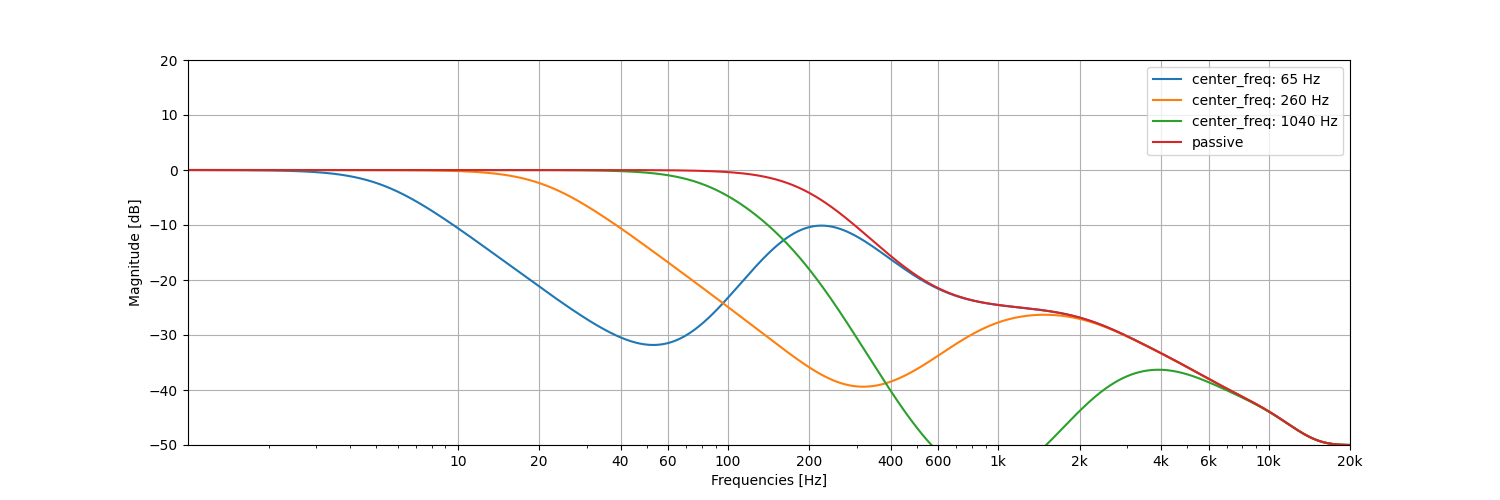

In [13]:
high_shelve1 = get_high_shelve(None, 200, 'lower', sampling_rate=44100, gain=-25, bandwidth=1.5)
high_shelve2 = get_high_shelve(None, 2000, 'lower', sampling_rate=44100, gain=-25, bandwidth=3)

for filters in testing_filters:
    filters += [high_shelve1[0], high_shelve2[0]]

testing_filters.append([high_shelve1[0], high_shelve2[0]])
testing_descriptors.append("passive")
plot_impulse_response_cascade(testing_filters, testing_descriptors)

### Create testing sets ###

In [ ]:
audio = {}
audio["pub"] = pf.io.read_audio("./test_set/public_-25.wav")
audio["airplane"] = pf.io.read_audio("./test_set/airplane_-25.wav")
audio["train"] = pf.io.read_audio("./test_set/train_-25.wav")
audio["mensa"] = pf.io.read_audio("./test_set/mensa_-25.wav")
audio["open_field"] = pf.io.read_audio("/Users/nptlinh/Desktop/BA-Code/test_set/open_field_-25.wav")


In [ ]:
# audio_passive = {}
# audio_tot = {}
# audio_tot_mismatch = {}
# for type, signal in audio.items():
#     signal_passive = apply_passive_filter(signal)
#     audio_passive[f'{type}'] = signal_passive
#     passive_crop = pf.dsp.time_window(signal_passive, interval=[0, 0.25, 9.75, 10], unit='s', crop='window')
#     pf.io.write_audio(passive_crop, filename=f'./test_set/{type}_passive.wav', subtype="FLOAT")
    
#     for freq in testing_freq:
#         signal_tot = create_testing_filter(-11, 25, 0, -40, freq, signal_passive, False)
#         signal_mismatch = create_testing_filter(-11, 25, 0, -40, freq, signal_passive, True)
#         audio_tot[f'{type}_{freq}'] = signal_tot

#         signal_tot_mismatch = signal_tot
#         signal_tot_mismatch[0] = signal_mismatch[0]
#         signal_tot_mismatch[1] = signal_tot[1]
#         audio_tot_mismatch[f'{type}_{freq}'] = signal_tot_mismatch

#         tot_crop_mismatch = pf.dsp.time_window(signal_tot_mismatch, interval=[0, 0.25, 9.75, 10], unit='s', crop='window')
#         tot_crop = pf.dsp.time_window(signal_tot, interval=[0, 0.25, 9.75, 10], unit='s', crop='window')
#         pf.io.write_audio(tot_crop, filename=f'./test_set/{type}_{freq}_tot.wav', subtype="FLOAT")
#         pf.io.write_audio(tot_crop_mismatch, filename=f'./test_set/{type}_{freq}_tot_mismatch.wav', subtype="FLOAT")
        

In [ ]:

# audio_tot_260 = {type: audio for type, audio in audio_tot_mismatch.items() if "260" in type}
# audio_tot_65 = {type: audio for type, audio in audio_tot_mismatch.items() if "65" in type}
# audio_tot_1040 = {type: audio for type, audio in audio_tot_mismatch.items() if "1040" in type}

    
# fig, ax = plot_freq(len(audio_tot_65.keys()), 2, audio_tot_65)

# fig, ax = plot_freq(len(audio_tot_260.keys()), 2, audio_tot_260, fig=fig, ax=ax)

# fig, ax = plot_freq(len(audio_tot_1040.keys()), 2, audio_tot_1040, fig=fig, ax=ax)


### Box Plot of results ###

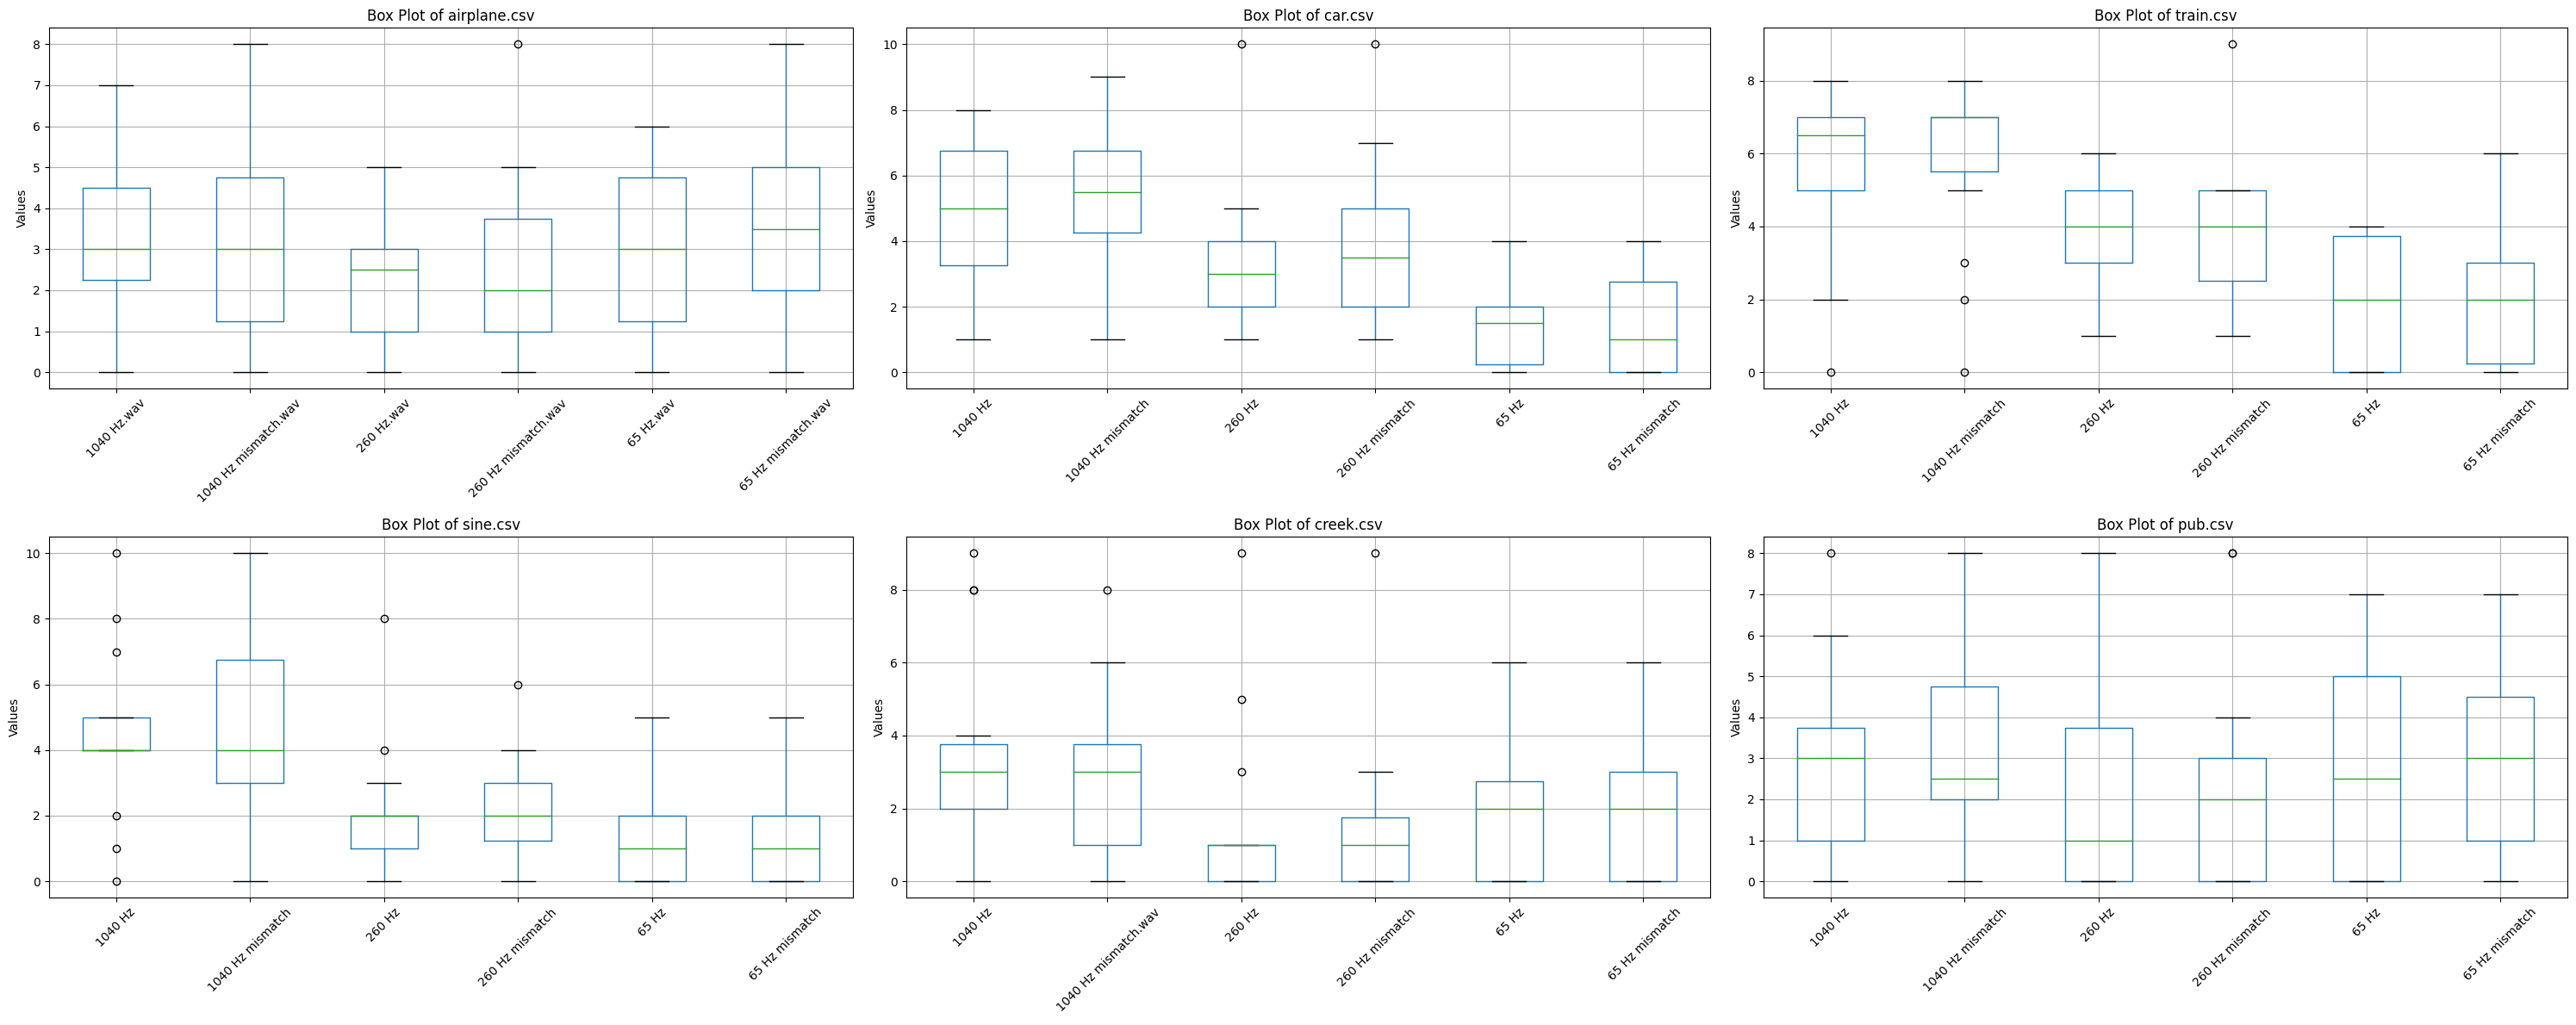

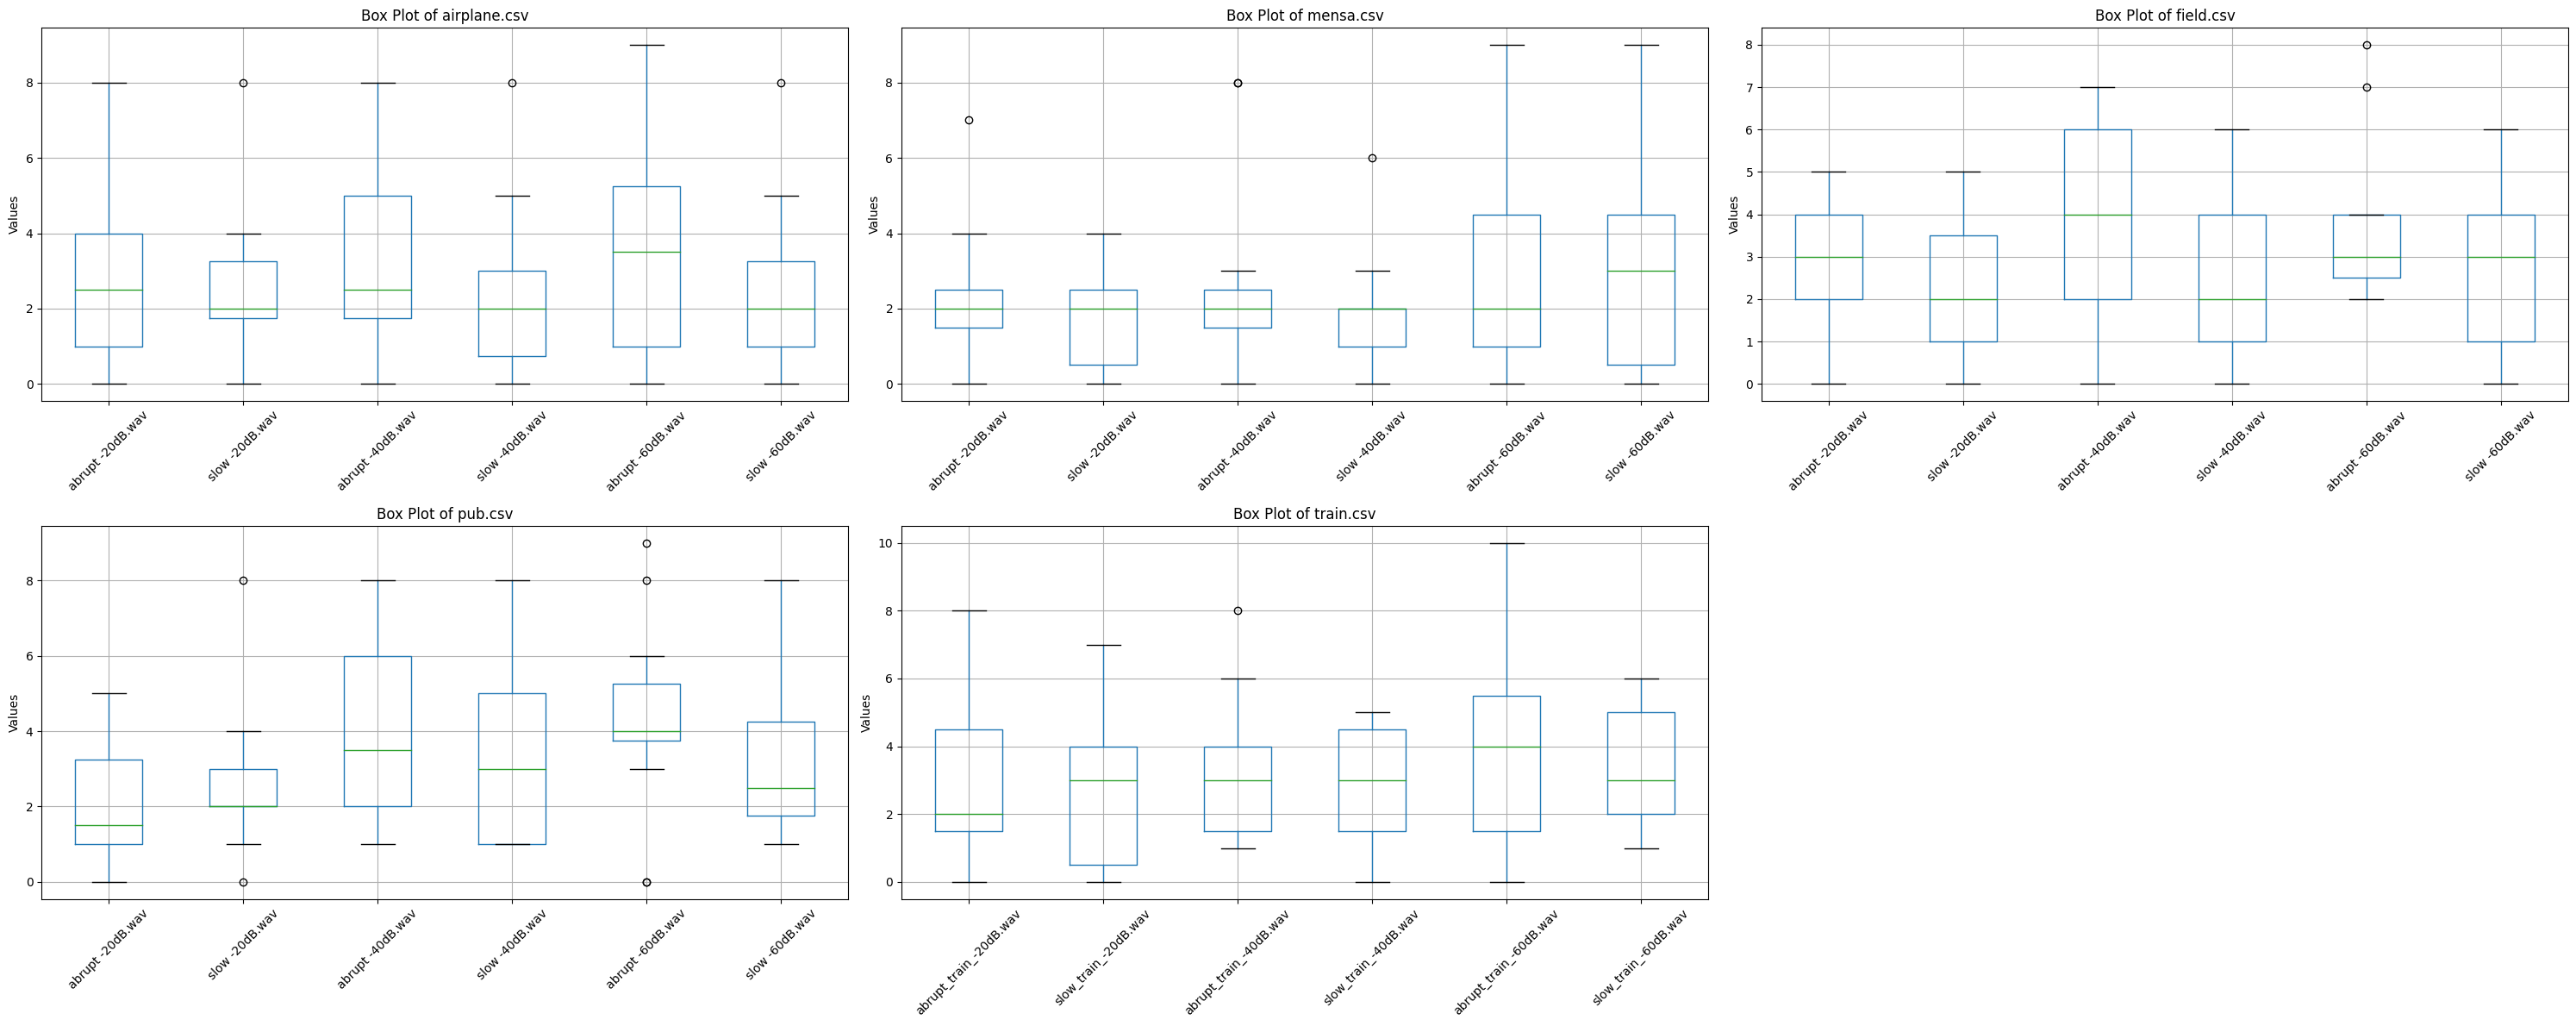

In [1]:
from gui_qt.plot_box import plot_box

results_filter_pos = ["/Users/nptlinh/Desktop/BA-Code/gui_qt/results/filter_pos/mod_airplane.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/filter_pos/mod_car.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/filter_pos/mod_train.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/filter_pos/mod_sine.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/filter_pos/mod_nature_creek.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/filter_pos/mod_pub.csv"]

# results_filter_pos = [r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\filter_pos\airplane.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\filter_pos\car.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\filter_pos\train.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\filter_pos\sine.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\filter_pos\nature_creek.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\filter_pos\pub.csv"]
plot_box(results_filter_pos)

results_transition = ["/Users/nptlinh/Desktop/BA-Code/gui_qt/results/transition/sorted_airplane.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/transition/sorted_mensa.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/transition/sorted_open_field.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/transition/sorted_pub.csv",
          "/Users/nptlinh/Desktop/BA-Code/gui_qt/results/transition/sorted_train.csv"]


# results_transition = [r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\transition\airplane.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\transition\mensa.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\transition\train.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\transition\pub.csv",
#             r"C:\Users\LinhNguyen\Desktop\BA_Code\gui_qt\results\transition\open_field.csv"]
plot_box(results_transition)

(<Figure size 1500x500 with 1 Axes>,
 <Axes: xlabel='Frequencies [Hz]', ylabel='Magnitude [dB]'>)

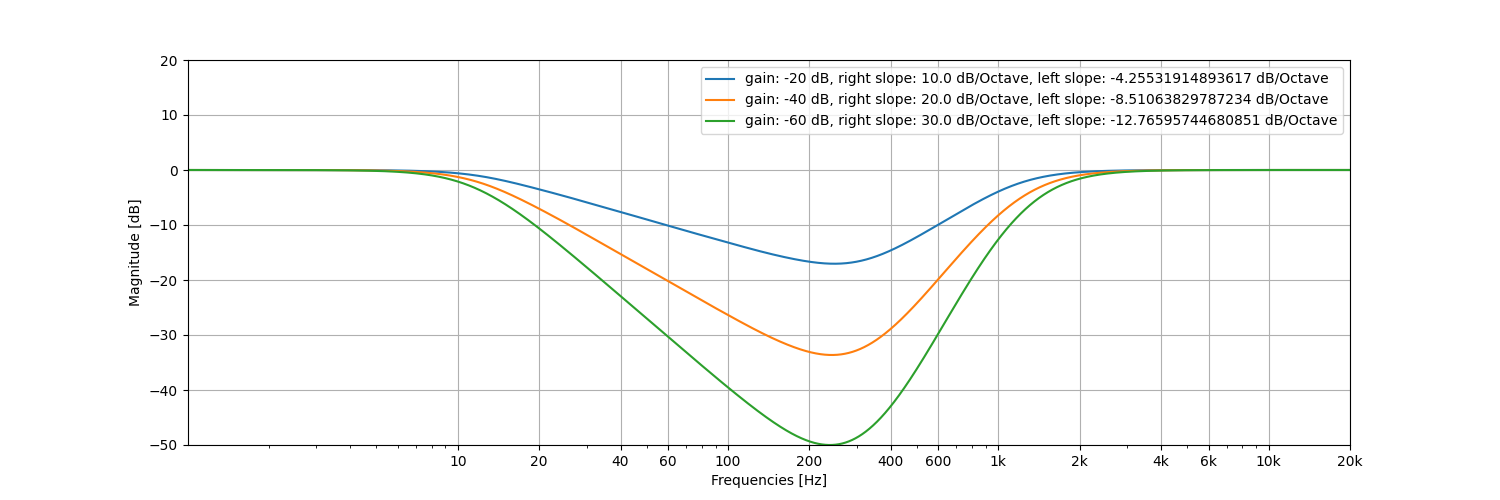

In [14]:
testing_filters = []
testing_descriptors = []
testing_gains = [-20, -40, -60]
bandwidth_left = 4.7
bandwidth_right = 2

for gain in testing_gains:
    left_slope = gain/bandwidth_left
    right_slope = -gain/bandwidth_right
    testing_filters.append(create_testing_filter(left_slope, right_slope, 0, gain, 300))
    testing_descriptors.append(f"gain: {gain} dB, right slope: {right_slope} dB/Octave, left slope: {left_slope} dB/Octave")

plot_impulse_response_cascade(testing_filters, testing_descriptors)

In [ ]:
descriptors = []
for index, filters in enumerate(testing_filters):
    filters += [high_shelve1[0], high_shelve2[0]]
    descriptors.append(f"Passive + Active, gain:{testing_gains[index]}")
    
testing_filters.append([high_shelve1[0], high_shelve2[0]])
descriptors.append("passive")
plot_impulse_response_cascade(testing_filters, descriptors)

In [ ]:
# audio_abrupt = {}
# audio_filtered = {}
# audio_crossfade_fast = {}
# audio_crossfade_slow = {}

# for type, signal in audio_passive.items():
#     crop_passive = pf.dsp.time_window(signal, interval=[8.5, 12.5], unit="s", crop="window")
#     pf.io.write_audio(crop_passive, filename=f"passive_{type}.wav", subtype="FLOAT")
#     for gain in testing_gains:
#         signal_crop = pf.dsp.time_window(signal, interval=[0, 20], window="boxcar", unit="s", crop="window")
#         signal_crop_half_1 = pf.dsp.time_window(signal, interval=[0, 10], window="boxcar", unit='s', crop='window') 
#         signal_crop_half_2 = pf.dsp.time_window(signal, interval=[10, 20], window="boxcar", unit="s", crop="window")
#         filtered_signal = create_testing_filter(gain/bandwidth_left, -gain/bandwidth_right, 0, gain, 300, signal_crop_half_2, False)
#         audio_filtered[f"{type}_{gain}"] = filtered_signal
        
#         fadein_abrupt = pf.dsp.time_window(filtered_signal, interval=[0.475, 0.525], shape="left", unit="s")
#         fadein_abrupt = pf.dsp.pad_zeros(fadein_abrupt, fadein_abrupt.sampling_rate*10, mode="beginning")
#         fadeout_abrupt = pf.dsp.time_window(signal_crop, interval=[10.475, 10.525], shape="right", unit="s")
#         combine_fast = fadeout_abrupt + fadein_abrupt
#         combine_fast = pf.dsp.time_window(combine_fast, interval=[8.475, 8.975, 12.025, 12.525], unit="s", crop="window")
#         audio_abrupt[f"{type}_{gain}"] = combine_fast
#         pf.io.write_audio(combine_fast, filename=f"abrupt_{type}_{gain}dB.wav", subtype="FLOAT")

#         fadein_slow = pf.dsp.time_window(filtered_signal, interval=[0, 1], shape="left", unit="s")
#         fadein_slow = pf.dsp.pad_zeros(fadein_slow, fadein_slow.sampling_rate*10, mode="beginning")
#         fadeout_slow = pf.dsp.time_window(signal_crop, interval=[10, 11], shape="right", unit="s")
#         combine_slow = fadeout_slow + fadein_slow
#         combine_slow = pf.dsp.time_window(combine_slow, interval=[8.5, 9, 12, 12.5], unit="s", crop="window")
#         audio_crossfade_slow[f"{type}_{gain}"] = combine_slow
#         pf.io.write_audio(combine_slow, filename=f"slow_{type}_{gain}dB.wav", subtype="FLOAT")


In [ ]:

# for type, signal in audio.items():
#     plt.figure()
#     plt.title(type)
#     plt.plot(signal.time[0].T)

In [ ]:
# audio_80 = {type: audio for type, audio in audio_filtered.items() if "80" in type}
# fig, ax = plot_freq(len(audio_passive.keys()), 2, audio_passive)

# plot_freq(len(audio_80.keys()), 2, audio_80 , fig=fig, ax=ax)

### Create Different coloured noise ###

In [ ]:
def normalize(signal, peak=0.9):
    for channel in range(signal.shape[0]):
        max_amplitude = np.max(np.abs(signal[channel]))
        if max_amplitude != 0:
            signal[channel] /= max_amplitude / peak
    return signal



def psd(duration, sampling_rate, calculate_weight = lambda frequencies: 1):
    samples = int(duration*sampling_rate)

    white_left = np.fft.rfft(np.random.randn(samples))
    white_right = np.fft.rfft(np.random.randn(samples))

    weight_left = calculate_weight(np.fft.rfftfreq(samples, d=1/sampling_rate))
    weight_right = calculate_weight(np.fft.rfftfreq(samples, d=1/sampling_rate))

    # Normalize weight
    weight_left = weight_left / np.sqrt(np.mean(weight_left**2))
    weight_right = weight_right / np.sqrt(np.mean(weight_right**2))

    # Apply weights to the white noise
    left_channel = np.fft.irfft(white_left * weight_left)
    right_channel = np.fft.irfft(white_right * weight_right)

    # Initialize and fill the sound array
    sound = np.zeros((2, samples))
    sound[0, :len(left_channel)] = left_channel
    sound[1, :len(right_channel)] = right_channel

    return sound


def colored_spectrum(func):
    return lambda duration, sampling_rate: psd(duration, sampling_rate, func)

@colored_spectrum
def white_noise(frequencies):
    return 1

@colored_spectrum
def pink_noise(frequencies):
    return 1/np.where(frequencies == 0, float('inf'), np.sqrt(frequencies))

@colored_spectrum
def brown_noise(frequencies):
    return 1/np.where(frequencies == 0, float("inf"), frequencies)

@colored_spectrum
def blue_noise(frequencies):
    return np.sqrt(frequencies)

@colored_spectrum
def violet_noise(frequencies):
    return frequencies


# white = normalize(white_noise(30, 44100))
# brown = normalize(brown_noise(30, 44100))
pink = normalize(pink_noise(30, 44100))
# blue = normalize(blue_noise(30, 44100))
# violet = normalize(violet_noise(30, 44100))

# print(np.max(brown[0]))
# print(np.max(brown[1]))

# sf.write("./white.wav", white.T, 44100)
sf.write("./pink.wav", pink.T, 44100)
# sf.write("./blue.wav", blue.T, 44100)
# sf.write("./violet.wav", violet.T, 44100)


In [ ]:
plt.figure()
pink_signal = pf.io.read_audio("./pink.wav")
pf.plot.freq(pink_signal)
